In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import itertools
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK

%matplotlib inline

In [2]:
batch_size_train = 32
batch_size_test = 32

In [3]:
class Overkill(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim = 1):
        super(Overkill, self).__init__()
        
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.input_dim = input_dim + 1 #Explicit bias term to simplify path norm
        self.output_dim = output_dim
        
        self.rho = None
        self.phi = None
        self.reinit()
    
    def reinit(self):
        self.phi = nn.Sequential(
            nn.Linear(self.input_dim, self.h1),
            nn.ReLU(),
            nn.Linear(self.h1, self.h1),
            nn.ReLU(),
        )
        self.rho = nn.Sequential(
            nn.Linear(self.h1, self.h2),
#             nn.BatchNorm1d(self.h2),
            nn.ReLU(),
            nn.Linear(self.h2, self.h3),
#             nn.BatchNorm1d(self.h3),
            nn.ReLU(),
            nn.Linear(self.h3, self.output_dim)
        )
    
    def forward(self, x):        
        batch_size, input_set_dim, input_dim = x.shape
        
        x = x.view(-1, input_dim)
        z = self.phi(x)
        z = z.view(batch_size, input_set_dim, -1)
        z = torch.mean(z, 1)
        return self.rho(z)
    
    def regularize(self, lamb):
        return 0.

In [4]:
class PointCloud(object):

    def __init__(self, cloud_size):
        self.cloud_size = cloud_size

    def __call__(self, image):

        flat = image.flatten()
        flat = (flat > 0.5).float() * flat
        
        vertex_count = torch.nonzero(flat).shape[0]
        
        size = min(self.cloud_size, vertex_count)
        
        args = torch.argsort(flat)[-size:].int()
        args = args[torch.randperm(size)]
        if size < self.cloud_size:
            repeat = self.cloud_size // size + 1
            args = args.repeat(repeat)[:self.cloud_size]
        
        
        rows = torch.floor_divide(args, 28)
        cols = torch.fmod(args, 28)
        
        image = torch.zeros(self.cloud_size, 4)
        
        image[:,0] = (rows - 14) / 28.
        image[:,1] = (cols - 14) / 28.
        image[:,2] = flat[args.long()]
        image[:,3] = 1 #bias term

        return image

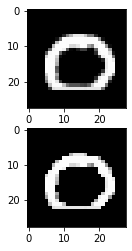

In [8]:
###TEST

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()
                             ),
  batch_size=batch_size_train, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (image, y) = next(examples)

image = image[0][0]
cloud_size = 200
x = PointCloud(cloud_size)(image)
rows = 28 * x[:,0] + 14
cols = 28 * x[:,1] + 14

new_im = torch.zeros_like(image)

for i in range(cloud_size):
    r = rows[i].int().item()
    c = cols[i].int().item()
    new_im[r,c] = x[i,2].item()

plt.subplot(2,1,1)
plt.imshow(image, cmap='gray', interpolation='none')
plt.subplot(2,1,2)
plt.imshow(new_im, cmap='gray', interpolation='none')        

In [9]:
cloud_size = 200
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 PointCloud(cloud_size)
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 PointCloud(cloud_size)
                             ])),
  batch_size=batch_size_test, shuffle=True)

torch.Size([32, 200, 4])
torch.Size([32])


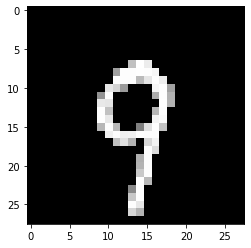

In [10]:
examples = enumerate(train_loader)
batch_idx, (batch_x, batch_y) = next(examples)
print(batch_x.shape)
print(batch_y.shape)

x = batch_x[0]

image = torch.zeros((28, 28))
for i in range(x.shape[0]):
    r = (28 * x[i,0] + 14).int().item()
    c = (28 * x[i,1] + 14).int().item()
    image[r,c] = x[i,2]
    
plt.imshow(image, cmap='gray', interpolation='none')

In [11]:
def train(model, dataloader, iterations, lamb = 0.1):
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.003)


    losses = []
    for i in range(iterations):
        print("iter", i)
        for batch_idx, (x, y) in enumerate(dataloader):
            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss += model.regularize(lamb)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
    
    return losses

def test(model, dataloader):
    model.eval()
    
    correct = 0.
    total = 0.
    
    for batch_idx, (x, y) in enumerate(dataloader):
        outputs = model(x)
        preds = torch.argmax(outputs, dim = 1)
        correct += preds.eq(y).sum()
        total += y.shape[0]
    
    return 1 - (correct / total)

In [12]:
def cross_validate(model, dataloader, iterations, lambs, verbose):
    models = []
    for lamb in lambs:
        model_copy = copy.deepcopy(model)
        losses = train(model_copy, dataloader, iterations, lamb)
        models.append(model_copy)
        if verbose:
            print(losses[::100])
    return models

In [13]:
def compare_models(hidden_dim, iterations, input_dim = 3, verbose = False):
        
    f1 = Symmetric(input_dim, hidden_dim, hidden_dim, 10)
    f2 = KNN(input_dim, hidden_dim, hidden_dim, 10)
    f3 = KK(input_dim, hidden_dim, hidden_dim, 10)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    
    lambs = [0., 1e-6, 1e-4, 1e-2]

    for model in models:
        print("model", model.__name__)
        cv_models = cross_validate(model, train_loader, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = test(cv_model, train_loader)
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 3
        run_errors = np.zeros(runs)
        for i in range(runs):
            print("run", i)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            train(model_copy, train_loader, iterations, lamb)
            run_errors[i] = test(model_copy, test_loader)
        
        mean_error = np.mean(run_errors)
        std_error = np.std(run_errors)
        
        print("mean: {}, std: {}".format(mean_error, std_error))
        
#         if log_plot:
#             plt.semilogy(N_list, mean_error, label = model.__name__)
#         else:
#             plt.plot(N_list, mean_error, label = model.__name__)
#         plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
#     plt.legend()
#     plt.ylim([1e-5, 1e-1]) 
#     plt.xlabel("N")
#     plt.ylabel("Mean Square Error")
#     narrow_str = "Narrow" if narrow else "Wide"
#     plt.title(narrow_str + " generalization for " + objective.__name__)
#     scale_str = "" if not scaleup else "scaled"
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scale_str)
# #     plt.show()
#     plt.close()

In [14]:
# compare_models(100, 3, verbose = True)

In [15]:
input_dim = 3
h1 = 100
h2 = 800
h3 = 800

model = Overkill(input_dim, h1, h2, h3, 10)
losses = train(model, train_loader, 10, lamb = 0.0)
print(losses[::100])

error = test(model, test_loader)
print(error)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
[2.304962635040283, 2.304004669189453, 2.313499927520752, 2.292806386947632, 2.2766780853271484, 1.8061996698379517, 1.4619487524032593, 1.4171719551086426, 1.2893046140670776, 1.2537320852279663, 0.9859843254089355, 0.9115166664123535, 0.8048770427703857, 1.3117586374282837, 0.8312364220619202, 0.8835158348083496, 1.0444718599319458, 1.0439244508743286, 1.0353549718856812, 0.8742231726646423, 0.755380392074585, 0.9939143061637878, 0.6384285688400269, 0.9634263515472412, 0.8039736151695251, 0.8794617652893066, 0.6583983302116394, 0.6040084958076477, 0.5601102709770203, 0.819321870803833, 0.7466979026794434, 0.6750922799110413, 0.8048166632652283, 0.5295870304107666, 0.6268677711486816, 0.8673180341720581, 0.7615747451782227, 0.3698125183582306, 0.5039823055267334, 0.5085453391075134, 0.3401818573474884, 0.5270726680755615, 0.523725688457489, 0.520521342754364, 0.8026604652404785, 0.7600938081741333, 0.682142913341522